# Let's make a full neural network using just NumPy!
This time, we'll allow it to have any number of hidden layers, any number of hidden units, and a choice of activation and loss function.

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import os

### Simple binary classification dataset

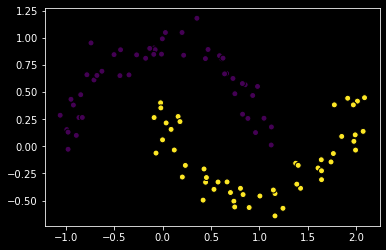

In [104]:
X, Y = make_moons(noise=0.1)
Y = np.expand_dims(Y, 1)
plt.style.use('dark_background')
plt.scatter(X.T[0], X.T[1], c=Y, edgecolors='black')
plt.show()

### Activation functions

In [105]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    D = np.copy(Z)
    D[D < 0] = 0
    D[D > 0] = 1

    return D

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

### Loss functions

In [106]:
def lse(Y, Y_hat):
    return ((Y - Y_hat) ** 2) / 2

def lse_derivative(Y, Y_hat):
    return Y_hat - Y

def nll(Y, Y_hat):
    return -(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

def nll_derivative(Y, Y_hat):
    return -(Y / Y_hat - (1 - Y) / (1 - Y_hat))

### Initialize model parameters

In [107]:
def init_parameters(layers):
    parameters = {}

    for i, layer in enumerate(layers):
        parameters[f'W{i + 1}'] = np.random.randn(layer['in_channels'], layer['out_channels'])
        parameters[f'b{i + 1}'] = np.random.randn(layer['out_channels'])

    return parameters

### Forward pass

In [108]:
def forward(X, layers, parameters, training=False):
    cache = {}

    for i, layer in enumerate(layers):
        W, b = parameters[f'W{i + 1}'], parameters[f'b{i + 1}']
        A_prev = X if i == 0 else cache[f'A{i}']

        Z = A_prev @ W + b

        if layer['activation'] == 'relu':
            g = relu
        elif layer['activation'] == 'sigmoid':
            g = sigmoid
        else:
            raise Exception('Activation function not supported:', layer['activation'])
            
        A = g(Z)
        cache[f'Z{i + 1}'], cache[f'A{i + 1}'] = Z, A

    Y_hat = cache[f'A{len(layers)}']

    if training:
        return Y_hat, cache
    else:
        return Y_hat

### Backprop

In [109]:
def backward(X, Y, layers, parameters, cache, loss):
    gradients = {}

    for i, layer in reversed(list(enumerate(layers))):
        if i == len(layers) - 1:
            A = cache[f'A{i + 1}']

            if loss == 'lse':
                loss_derivative = lse_derivative
            elif loss == 'nll':
                loss_derivative = nll_derivative
            else:
                raise Exception('Loss function not supported:', loss)

            dA = loss_derivative(Y, A)
        else:
            dZ_next = gradients[f'dZ{i + 2}']
            W_next = parameters[f'W{i + 2}']

            dA = dZ_next @ W_next.T

        Z = cache[f'Z{i + 1}']

        if layer['activation'] == 'relu':
            activation_derivative = relu_derivative
        elif layer['activation'] == 'sigmoid':
            activation_derivative = sigmoid_derivative
        else:
            raise Exception('Activation function not supported:', layer['activation'])
        
        dZ = dA * activation_derivative(Z)
        gradients[f'dA{i + 1}'], gradients[f'dZ{i + 1}'] = dA, dZ

        A_prev = X if i == 0 else cache[f'A{i}']
        N = Y.shape[0]

        dW = (A_prev.T @ dZ) / N
        db = np.sum(dZ, axis=0) / N
        gradients[f'dW{i + 1}'], gradients[f'db{i + 1}'] = dW, db

    return gradients

### Point classification accuracy

In [110]:
def acc(Y, Y_hat):
    pred = np.copy(Y_hat)
    pred[pred < 0.5] = 0
    pred[pred >= 0.5] = 1

    return np.sum(Y == pred) / Y.shape[0]

### Plot decision boundary

In [111]:
def plot_boundary(X, Y, parameters, epoch):
    res = 50
    x1, x2 = -1.5, 2.5
    y1, y2 = -1, 1.5
    grid_x, grid_y = np.meshgrid(np.linspace(x1, x2, num=res), np.linspace(y1, y2, num=res))

    grid = np.concatenate((grid_x.reshape((res ** 2, 1)), grid_y.reshape((res ** 2, 1))), axis=1)
    Y_hat = forward(grid, layers, parameters)

    num_contours = 2 * 5 + 1
    plt.contourf(grid_x, grid_y, Y_hat.reshape(res, res), np.linspace(0, 1, num=num_contours), alpha=0.7)
    plt.contour(grid_x, grid_y, Y_hat.reshape(res, res), [0.5])
    plt.scatter(X.T[0], X.T[1], c=Y, edgecolors='black')
    plt.title(f'decision boundary after epoch {epoch + 1:5d}')

    if not os.path.isdir('./boundaries'):
        os.mkdir('./boundaries')
    
    plt.savefig(f'./boundaries/boundary_epoch_{epoch + 1:05d}.png')
    plt.close()

### Plot loss curve

In [112]:
def plot_loss(losses):
    plt.plot(losses)
    plt.title('loss after each epoch')
    
    if not os.path.isdir('./img'):
        os.mkdir('./img')

    plt.savefig(f'./img/loss_curve.png')
    plt.close()

### Training

In [113]:
def train(X, Y, layers, parameters, loss, n_iterations, alpha):
    Y_hat, cache = forward(X, layers, parameters, training=True)
    
    losses = []

    for epoch in range(n_iterations):
        gradients = backward(X, Y, layers, parameters, cache, loss)
        
        for i in range(len(layers)):
            parameters[f'W{i + 1}'] -= alpha * gradients[f'dW{i + 1}']
            parameters[f'b{i + 1}'] -= alpha * gradients[f'db{i + 1}']

        Y_hat, cache = forward(X, layers, parameters, training=True)

        if loss == 'lse':
            l = lse
        elif loss == 'nll':
            l = nll
        else:
            raise Exception('Loss function not supported:', loss)

        epoch_loss = np.sum(l(Y, Y_hat))
        accuracy = acc(Y, Y_hat)
        print(f'epoch {epoch + 1:5d}: loss = {epoch_loss:6f}, accuracy = {accuracy:6f}')

        if (epoch + 1) % 100 == 0:
            plot_boundary(X, Y, parameters, epoch)

        losses.append(epoch_loss)

    plot_loss(losses)

### Specify model details

In [114]:
layers = [
    {'in_channels': X.shape[1], 'out_channels': 4, 'activation': 'relu'},
    {'in_channels': 4, 'out_channels': 4, 'activation': 'relu'},
    {'in_channels': 4, 'out_channels': Y.shape[1], 'activation': 'sigmoid'}
]

loss = 'nll'

In [115]:
parameters = init_parameters(layers)

train(X, Y, layers, parameters, loss, 2000, 0.1)

epoch     1: loss = 122.494500, accuracy = 0.490000
epoch     2: loss = 76.121588, accuracy = 0.450000
epoch     3: loss = 71.882494, accuracy = 0.530000
epoch     4: loss = 68.683742, accuracy = 0.570000
epoch     5: loss = 66.292000, accuracy = 0.610000
epoch     6: loss = 64.358783, accuracy = 0.620000
epoch     7: loss = 62.807340, accuracy = 0.630000
epoch     8: loss = 61.463816, accuracy = 0.640000
epoch     9: loss = 60.331118, accuracy = 0.660000
epoch    10: loss = 59.360528, accuracy = 0.700000
epoch    11: loss = 58.540311, accuracy = 0.720000
epoch    12: loss = 57.834643, accuracy = 0.720000
epoch    13: loss = 57.198489, accuracy = 0.720000
epoch    14: loss = 56.619979, accuracy = 0.720000
epoch    15: loss = 56.091621, accuracy = 0.730000
epoch    16: loss = 55.595066, accuracy = 0.740000
epoch    17: loss = 55.120649, accuracy = 0.740000
epoch    18: loss = 54.660197, accuracy = 0.750000
epoch    19: loss = 54.205921, accuracy = 0.750000
epoch    20: loss = 53.752159,

In [116]:
!convert -delay 1 -loop 0 ./boundaries/*.png ./img/decision_boundary.gif